<a href="https://colab.research.google.com/github/Oz-art/Instance-Segmentation/blob/main/Vehicle_parts_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -e .

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.7 MB/s eta 0:11:31tcmalloc: large alloc 1147494400 bytes == 0x561e462d6000 @  0x7fd28eaee615 0x561e0d7dd3bc 0x561e0d8be18a 0x561e0d7e01cd 0x561e0d8d2b3d 0x561e0d854458 0x561e0d84f02f 0x561e0d7e1aba 0x561e0d8542c0 0x561e0d84f02f 0x561e0d7e1aba 0x561e0d850cd4 0x561e0d8d3986 0x561e0d850350 0x561e0d8d3986 0x561e0d850350 0x561e0d8d3986 0x561e0d850350 0x561e0d7e1f19 0x561e0d825a79 0x561e0d7e0b32 0x561e0d8541dd 0x561e0d84f02f 0x561e0d7e1aba 0x561e0d850cd4 0x561e0d84f02f 0x561e0d7e1aba 0x561e0d84feae 0x561e0d7e19da 0x561e0d850108 0x561e0d84f02f
     |████████████████▌               | 1055.7 MB 1.5 MB/s eta 0:10:42tcmalloc: large alloc 1434370048 bytes == 0x561e8a92c000 @  0x7fd28eaee615 0x561e0d7dd3bc 0x561e0d8be18a 0x561e0d7e01cd 0x561e0d8d2b3d 0x561e0d854458 0x561e0d84f02f 0x561e0d7e1aba 0x561e0d8542c0 0x561e0d84f02f 0x561e0d7e1aba 0x561e0d850cd4 0x561e0d8d3986 0x561e0d8503

In [3]:
from mmcv import collect_env
collect_env()

{'CUDA available': True,
 'CUDA_HOME': '/usr/local/cuda',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'GPU 0': 'Tesla K80',
 'MMCV': '1.4.6',
 'MMCV CUDA Compiler': '11.1',
 'MMCV Compiler': 'GCC 7.3',
 'NVCC': 'Build cuda_11.1.TC455_06.29190527_0',
 'OpenCV': '4.1.2',
 'PyTorch': '1.9.0+cu111',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.1.2 (Git Hash 98be7e8afa711dc9b66c8ff3504129cb82013cdb)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86\n  - CuDNN

In [4]:
import re
import os

%cd '/content/mmdetection'
mmdetection_dir = '/content/mmdetection'
coco_file = os.path.join(mmdetection_dir, "mmdet/datasets/coco.py")

classes_names = ['back_bumper', 'back_glass', 'back_left_door', 'back_left_light', 'back_right_door', 'back_right_light', 'front_bumper', 'front_glass', 'front_left_door', 'front_left_light', 'front_right_door', 'front_right_light', 'hood', 'left_mirror', 'right_mirror', 'tailgate', 'trunk', 'wheel']

fname = coco_file
with open(fname) as f:
    s = f.read()
    s = re.sub('CLASSES = \(.*?\)',
               'CLASSES = ({})'.format(", ".join(["\'{}\'".format(name) for name in classes_names])), s, flags=re.S)
with open(fname, 'w') as f:
    f.write(s)
!cat {coco_file}

/content/mmdetection
# Copyright (c) OpenMMLab. All rights reserved.
import contextlib
import io
import itertools
import logging
import os.path as osp
import tempfile
import warnings
from collections import OrderedDict

import mmcv
import numpy as np
from mmcv.utils import print_log
from terminaltables import AsciiTable

from mmdet.core import eval_recalls
from .api_wrappers import COCO, COCOeval
from .builder import DATASETS
from .custom import CustomDataset


@DATASETS.register_module()
class CocoDataset(CustomDataset):

    CLASSES = ('back_bumper', 'back_glass', 'back_left_door', 'back_left_light', 'back_right_door', 'back_right_light', 'front_bumper', 'front_glass', 'front_left_door', 'front_left_light', 'front_right_door', 'front_right_light', 'hood', 'left_mirror', 'right_mirror', 'tailgate', 'trunk', 'wheel')

    PALETTE = [(220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230),
               (106, 0, 228), (0, 60, 100), (0, 80, 100), (0, 0, 70),
               (0, 0, 192), (

In [5]:
from mmcv import Config
cfg = Config.fromfile('./configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_1x_coco.py')

In [6]:
pwd

'/content/mmdetection'

In [7]:
cfg.dataset_type = 'CocoDataset'
cfg.classes = ('back_bumper', 'back_glass', 'back_left_door', 'back_left_light', 'back_right_door', 'back_right_light', 'front_bumper', 'front_glass', 'front_left_door', 'front_left_light', 'front_right_door', 'front_right_light', 'hood', 'left_mirror', 'right_mirror', 'tailgate', 'trunk', 'wheel')


In [8]:
%cd content/mmdetection/

[Errno 2] No such file or directory: 'content/mmdetection/'
/content/mmdetection


In [9]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
PREFIX='content/drive/MyDrive/dataset_custom/'
cfg.data.test.ann_file = PREFIX+'testset/annotations.json'
cfg.data.test.img_prefix = PREFIX+'testset'
cfg.data.test.classes = cfg.classes

cfg.data.train.ann_file = PREFIX+'trainingset/annotations.json'
cfg.data.train.img_prefix = PREFIX+'trainingset'
cfg.data.train.classes = cfg.classes

cfg.data.val.ann_file = PREFIX+'testset/annotations.json'
cfg.data.val.img_prefix = PREFIX+'testset'
cfg.data.val.classes = cfg.classes

# modify num classes of the model in box head and mask head
cfg.model.roi_head.bbox_head.num_classes = 18
cfg.model.roi_head.mask_head.num_classes = 18


# We can still the pre-trained Mask RCNN model to obtain a higher performance
cfg.load_from = PREFIX+'pretrained/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = PREFIX+'checkpoint'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 100


# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 3
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 3

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.runner.max_epochs=12
runner = dict(type='EpochBasedRunner', max_epochs=12)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cross

In [11]:
%cd ..
%cd ..

/content
/


In [12]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
import mmcv
import os.path as osp


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
loading annotations into memory...


2022-03-18 02:21:52,706 - mmdet - INFO - load checkpoint from local path: content/drive/MyDrive/dataset_custom/pretrained/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


Done (t=0.45s)
creating index...
index created!


2022-03-18 02:21:55,318 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([19, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([19]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([72, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([72]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 2.5 task/s, elapsed: 41s, ETA:     0s

2022-03-18 02:35:04,229 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.57s).
Accumulating evaluation results...


2022-03-18 02:35:05,099 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.339
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.546
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.374
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).


/content/mmdetection/mmdet/datasets/coco.py:465: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.65s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-03-18 02:35:06,394 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.388
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.565
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.347
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=0.29s).


/content/mmdetection/mmdet/core/mask/structures.py:1071: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bitmap_mask = maskUtils.decode(rle).astype(np.bool)
2022-03-18 02:37:11,120 - mmdet - INFO - Epoch [4][100/200]	lr: 2.500e-03, eta: 0:34:51, time: 1.242, data_time: 0.034, memory: 2793, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0226, loss_cls: 0.2672, acc: 88.5908, loss_bbox: 0.2767, loss_mask: 0.1331, loss: 0.7054
2022-03-18 02:39:13,820 - mmdet - INFO - Epoch [4][200/200]	lr: 2.500e-03, eta: 0:32:47, time: 1.227, data_time: 0.016, memory: 2793, loss_rpn_cls: 0.0064, loss_rpn_bbox: 0.0235, loss_cls: 0.2631, acc: 89.0566, loss_bbox: 0.2741, loss_mask: 0.1297, loss: 0.6

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 2.5 task/s, elapsed: 39s, ETA:     0s

2022-03-18 02:48:12,290 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.54s).
Accumulating evaluation results...


2022-03-18 02:48:13,119 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.592
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.438
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.464
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.654
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.576
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.27s).
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/content/mmdetection/mmdet/datasets/coco.py:465: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.58s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-03-18 02:48:14,064 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.607
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.491
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.408
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=0.28s).


/content/mmdetection/mmdet/core/mask/structures.py:1071: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bitmap_mask = maskUtils.decode(rle).astype(np.bool)
2022-03-18 02:50:20,266 - mmdet - INFO - Epoch [7][100/200]	lr: 2.500e-03, eta: 0:22:37, time: 1.257, data_time: 0.033, memory: 2793, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0208, loss_cls: 0.2207, acc: 90.6074, loss_bbox: 0.2233, loss_mask: 0.1136, loss: 0.5820
2022-03-18 02:52:23,243 - mmdet - INFO - Epoch [7][200/200]	lr: 2.500e-03, eta: 0:20:34, time: 1.229, data_time: 0.015, memory: 2793, loss_rpn_cls: 0.0040, loss_rpn_bbox: 0.0203, loss_cls: 0.2183, acc: 90.5840, loss_bbox: 0.2254, loss_mask: 0.1113, loss: 0.5

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 2.6 task/s, elapsed: 39s, ETA:     0s

2022-03-18 03:01:25,256 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.79s).
Accumulating evaluation results...


2022-03-18 03:01:26,313 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.593
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.487
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.469
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.693
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.688
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.24s).
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/content/mmdetection/mmdet/datasets/coco.py:465: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.54s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-03-18 03:01:27,190 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.441
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.605
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.502
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=0.25s).


/content/mmdetection/mmdet/core/mask/structures.py:1071: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bitmap_mask = maskUtils.decode(rle).astype(np.bool)
2022-03-18 03:03:33,964 - mmdet - INFO - Epoch [10][100/200]	lr: 2.500e-04, eta: 0:10:19, time: 1.262, data_time: 0.033, memory: 2793, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0159, loss_cls: 0.1837, acc: 92.2158, loss_bbox: 0.1691, loss_mask: 0.1049, loss: 0.4771
2022-03-18 03:05:37,084 - mmdet - INFO - Epoch [10][200/200]	lr: 2.500e-04, eta: 0:08:15, time: 1.231, data_time: 0.016, memory: 2793, loss_rpn_cls: 0.0029, loss_rpn_bbox: 0.0157, loss_cls: 0.1765, acc: 92.0547, loss_bbox: 0.1622, loss_mask: 0.1000, loss: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100/100, 2.6 task/s, elapsed: 39s, ETA:     0s

2022-03-18 03:14:39,772 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.48s).
Accumulating evaluation results...


2022-03-18 03:14:40,529 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.422
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.588
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.484
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.482
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.699
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.610
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.696
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.25s).
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/content/mmdetection/mmdet/datasets/coco.py:465: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.56s).
Accumulating evaluation results...


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-03-18 03:14:41,425 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.600
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.510
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.270
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=0.26s).


/content/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


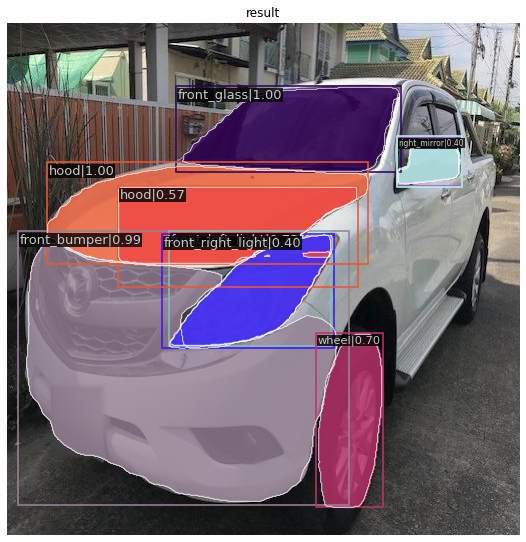

In [15]:
from mmdet.apis import inference_detector, show_result_pyplot


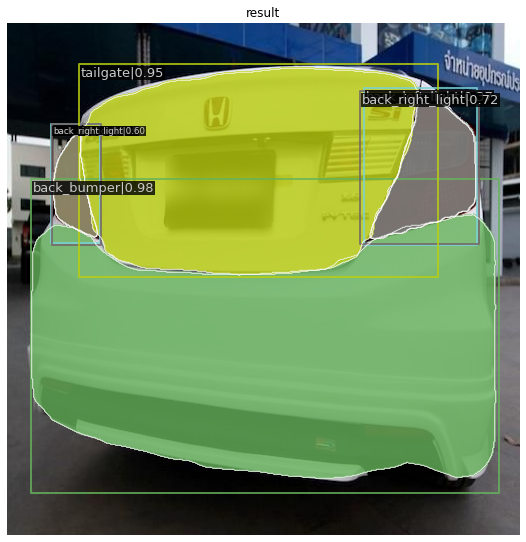

In [25]:
img = mmcv.imread('content/drive/MyDrive/dataset_custom/train75.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [ ]:

# # Choose to use a config and initialize the detector
# config = 'content/mmdetection/configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# # Setup a checkpoint file to load
# checkpoint = 'content/drive/MyDrive/dataset_custom/checkpoint/epoch_24.pth'

# # Set the device to be used for evaluation
# device='cuda:0'





In [ ]:
# %cd ..
# %cd ..

In [ ]:
# import mmcv
# from mmcv.runner import load_checkpoint

# from mmdet.apis import inference_detector, show_result_pyplot
# from mmdet.models import build_detector

# # Load the config
# config = mmcv.Config.fromfile(config)
# # Set pretrained to be None since we do not need pretrained model here
# config.model.pretrained = None
# # Initialize the detector
# model = build_detector(config.model)

# # Load checkpoint
# checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# # Set the classes of models for inference
# model.CLASSES = checkpoint['meta']['CLASSES']

# # We need to set the model's cfg for inference
# model.cfg = config

# # Convert the model to GPU
# model.to(device)
# # Convert the model into evaluation mode
# model.eval()

In [ ]:
# Use the detector to do inference
img = 'content/drive/MyDrive/dataset_custom/train157.jpg'
result = inference_detector(model, img)

In [ ]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)